# Database Consistency Checks

This notebook checks the top-level `tiles-SPECPROD.(fits|csv)` and `exposures-SPECPROD.(fits|csv)` files for self-consistency in prepartion for loading these files into a database.

## Imports

In [1]:
%matplotlib inline
import os
import glob
import json
from pytz import utc
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time

from desiutil.iers import freeze_iers
from desiutil.log import get_logger, DEBUG, INFO

from desispec.io.meta import faflavor2program
from desispec.io.util import checkgzip
import desispec.database.redshift as dsr
from desispec.database.util import targetphotid

from desitarget.targets import decode_targetid
freeze_iers()

INFO:iers.py:82:freeze_iers: Freezing IERS table used by astropy time, coordinates.


## Important Setup

In [2]:
specprod = os.environ['SPECPROD'] = 'fuji'
overwrite = True

In [3]:
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(os.environ['DESI_ROOT'], 'public', 'edr', 'spectro', 'redux')

## Test loading targeting data

In [4]:
release = 'edr'
targetphot_version = 'v1.0'
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(os.environ['DESI_ROOT'], 'public', release, 'spectro', 'redux')

In [5]:
# targetphot_potential_file = os.path.join(os.environ['DESI_ROOT'], 'public', release, 'vac', 'lsdr9-photometry', os.environ['SPECPROD'], targetphot_version, 'potential-targets', f"targetphot-potential-{os.environ['SPECPROD']}.fits")
targetphot_potential_file = os.path.join(os.environ['SCRATCH'], f"targetphot-potential-{os.environ['SPECPROD']}.fits")
targetphot_potential = Table.read(targetphot_potential_file, hdu=1)

In [5]:
# targetphot_file = os.path.join(os.environ['DESI_ROOT'], 'public', release, 'vac', 'lsdr9-photometry', os.environ['SPECPROD'], targetphot_version, 'observed-targets', f"targetphot-{os.environ['SPECPROD']}.fits")
targetphot_file = os.path.join(os.environ['SCRATCH'], f"targetphot-{os.environ['SPECPROD']}.fits")
targetphot = Table.read(targetphot_file, hdu=1)

In [ ]:
ls_id = (targetphot['RELEASE'].data.astype(np.int64) << 40) | (targetphot['BRICKID'].data.astype(np.int64) << 16) | targetphot['BRICK_OBJID'].data.astype(np.int64)

### For a given `TARGETID`, which columns are always the same?

In [6]:
targetid = targetphot['TARGETID'].data
# targetid = targetphot_potential['TARGETID'].data

In [7]:
unique_targetid, unique_indexes, targetid_indexes, targetid_counts = np.unique(targetid, return_index=True, return_inverse=True, return_counts=True)
assert (unique_targetid[targetid_indexes] == targetid).all()

In [8]:
duplicate_targetid = np.nonzero(targetid_counts > 1)[0]

In [10]:
# Pre-find rows with duplicate TARGETID.
targetphot_cache = os.path.join(os.environ['SCRATCH'], os.path.splitext(os.path.basename(targetphot_file))[0] + '.json')
# targetphot_cache = os.path.join(os.environ['SCRATCH'], os.path.splitext(os.path.basename(targetphot_potential_file))[0] + '.json')
if os.path.exists(targetphot_cache):
    print("Loading from cache")
    with open(targetphot_cache) as fp:
        targetid_to_duplicates = json.load(fp)
else:
    print("Creating...")
    targetid_to_duplicates = dict()
    for i in duplicate_targetid:
        t = unique_targetid[i]
        rows = np.nonzero(targetid_indexes == i)[0]
        assert rows.shape[0] > 1
        targetid_to_duplicates[t] = rows

Loading from cache


In [12]:
anomalous_targetid = dict()
for t in targetid_to_duplicates:
    rows = targetphot[targetid_to_duplicates[t]]
    # rows = targetphot_potential[targetid_to_duplicates[t]]
    for c in ('RELEASE', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID', 'MORPHTYPE',
              'RA', 'RA_IVAR', 'DEC', 'DEC_IVAR',
              'DCHISQ',
              'EBV',
              'FLUX_G', 'FLUX_R', 'FLUX_Z',
              'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z',
              'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z',
              'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z',
              'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z',
              'FRACIN_G', 'FRACIN_R', 'FRACIN_Z',
              'NOBS_G', 'NOBS_R', 'NOBS_Z',
              'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
              'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
              'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4',
              'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4',
              'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4',
              'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z',
              'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
              'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z',
              'REF_EPOCH',
              'WISEMASK_W1', 'WISEMASK_W2',
              'MASKBITS',
              'LC_FLUX_W1', 'LC_FLUX_W2', 'LC_FLUX_IVAR_W1', 'LC_FLUX_IVAR_W2',
              'LC_NOBS_W1', 'LC_NOBS_W1', 'LC_MJD_W1', 'LC_MJD_W2',
              'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2',
              'SHAPE_R_IVAR', 'SHAPE_E1_IVAR', 'SHAPE_E2_IVAR',
              'SERSIC', 'SERSIC_IVAR',
              'REF_ID', 'REF_CAT',
              'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR',
              'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR',
              'GAIA_PHOT_RP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR',
              'GAIA_PHOT_BP_RP_EXCESS_FACTOR', 'GAIA_ASTROMETRIC_EXCESS_NOISE',
              'GAIA_DUPLICATED_SOURCE', 'GAIA_ASTROMETRIC_SIGMA5D_MAX', 'GAIA_ASTROMETRIC_PARAMS_SOLVED',
              'PARALLAX', 'PARALLAX_IVAR', 'PMRA', 'PMRA_IVAR', 'PMDEC', 'PMDEC_IVAR',
              'PHOTSYS'):
        if isinstance(rows[c], MaskedColumn):
            try:
                assert (rows[c].data.data == rows[c].data.data[0]).all()
            except:
                try:
                    assert np.isnan(rows[c].data.data).all()
                except:
                    # print(t, c, rows[c].data.data)
                    if t in anomalous_targetid:
                        anomalous_targetid[t].append(c)
                    else:
                        anomalous_targetid[t] = [c]
        else:
            try:
                assert (rows[c] == rows[c][0]).all()
            except:
                # print(t, rows[c])
                if t in anomalous_targetid:
                    anomalous_targetid[t].append(c)
                else:
                    anomalous_targetid[t] = [c]

In [13]:
for k in anomalous_targetid:
    if len(anomalous_targetid[k]) > 25:
        print(k)
        

39627751501597155
39627751551930903
39627751556125725
39627751560320497
39627751564509817
39627757524618460
39627757528812204
39627757533007506
39627757537199789
39627757541394637
39627757549783949
39627757612699212
39627757616894164
39627763564415895
39627763572802627
39627763581190847
39627763585384930
39627763585385564
39627763585389013
39627763589583588
39627763635722280
39627763648304723
39627764147422442
39627764197758556
39627769608405342
39627769608406176
39627769612603519
39627769616795885
39627769625183463
39627769625185551
39627769625187500
39627769625188009
39627769629376829
39627769633576120
39627769637769409
39627769637769566
39627769641961088
39627769658739474
39627769675515232
39627769679710420
39627769683905623
39627769688098041
39627770237556228
39627775652400732
39627775664983704
39627775669176042
39627775669179770
39627775698535465
39627775723704055
39627781692196617
39627781700587913
39627781708975290
39627781713168519
39627781713169091
39627781713172375
3962778171

In [15]:
targetphot[targetphot['TARGETID'] == 39633342945034370]

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SCND_TARGET,SV1_SCND_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,SURVEY,PROGRAM,TILEID
int16,int32,bytes8,int32,bytes4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,float32,float32,float32,float32,bytes1,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes7,bytes6,int32
9011,606974,2429p565,130,EXP,242.71695504288368,186871150000.0,56.39745319526946,278461940000.0,15360.508 .. 16669.52,0.0075925468,3.7990022,7.2595496,11.404786,322.2823,126.88182,41.772522,0.9777752,0.9849742,0.99156725,0.028018516,0.022679966,0.0035326954,0.0037034135,0.0035049778,0.011865248,0.99991065,0.99988246,1.0005194,3,3,3,664.81537,240.07257,93.21697,472.95422,168.5639,46.35529,14.416222,16.53251,115.44678,-555.5161,5.646243,1.8554549,0.0065292167,7.658246e-05,0.9987141,0.9992101,0.9998315,0.99993634,0,0,0,2.059164,3.9348764,6.1817093,2.059164,3.9348764,6.1817093,0.0,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.5915003,-0.31639335,0.049443964,9657.734,2631.7854,1961.5022,1.0,0.0,0,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,N,39633342945034370,0.9966197572253644,4,2000,1,11524,0,0,0,0,5764607523034234880,4112,0,0,0,0,0,0,0,0,1125899906975744,0,0,sv1,other,80865
0,0,--,0,--,242.716953459109,0.0,56.3974530695522,0.0,0.0 .. 0.0,0.0,3.7990022,7.2595496,11.404786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2015.5,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,--,3963334294503437

In [16]:
np.unique(targetphot['REF_EPOCH'])

0.0
1999.216
1999.218
2000.0
2000.259
2000.338
2000.341
2001.138
2001.211
2001.285
2001.288


In [ ]:
decode_targetid(39628459890181216)

In [ ]:
len(list(anomalous_targetid.keys()))

In [ ]:
len(targetphot), len(unique_targetid), len(duplicate_targetid)

In [ ]:
n_ref_count = 0
for t in anomalous_targetid:
    if len(anomalous_targetid[t]) == 1 and anomalous_targetid[t][0] == 'REF_EPOCH':
        n_ref_count += 1
n_ref_count

In [11]:
anomaly_counts = np.array([len(anomalous_targetid[t]) for t in anomalous_targetid])

In [12]:
def inthist(foo, show=False):
    """Create a histogram of integer values.

    Parameters
    ----------
    foo : :class:`numpy.ndarray`
        An array containing integers.
    show : :class:`bool`, optional
        If ``True``, create a histogram and return the matplotlib.axes.Axes
        instance.

    Returns
    -------
    :class:`tuple`
    """
    xmin = min(foo)
    xmax = max(foo)
    x = np.arange( xmin, xmax+1 )
    n = np.zeros( x.shape, dtype=x.dtype )
    for k in range(len(n)):
        n[k] = np.sum( foo == x[k] )
    if show:
        fig = plt.figure(dpi=100)
        ax = fig.add_subplot(111)
        b = ax.bar(x, n, align='center', width=0.5, color='k')
        ax.set_xlim(xmin-1, xmax+1)
        # ax.set_ylim(0, np.ceil(max(n)/10.0)*10.0)
        # ax.set_ylim(0, 10**np.ceil(np.log10(max(n))))
        return (fig, ax)
    else:
        return (n, x)


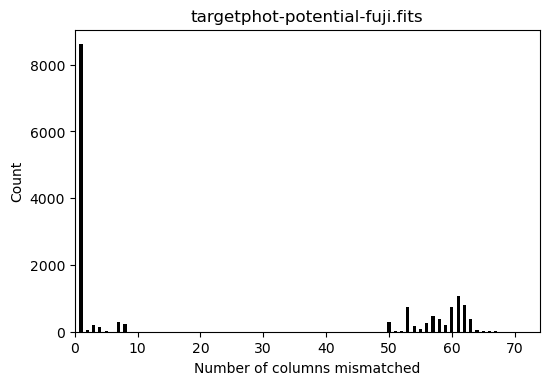

In [13]:
fig, ax = inthist(anomaly_counts, show=True)
foo = ax.set_xlabel('Number of columns mismatched')
foo = ax.set_ylabel('Count')
# foo = ax.set_title('targetphot-fuji.fits')
foo = ax.set_title('targetphot-potential-fuji.fits')
# fig.savefig(os.path.join(os.environ['HOME'], 'anomaly_counts.png'))
fig.savefig(os.path.join(os.environ['HOME'], 'anomaly_counts_potential.png'))

In [ ]:
for t in duplicate_targetid:
    rows = targetphot[duplicate_targetid[t]]
    for c in ('SUBPRIORITY', 'OBSCONDITIONS', 'PRIORITY_INIT', 'NUMOBS_INIT', 'HPXPIXEL',
              'CMX_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET',
              'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET',
              'SV2_DESI_TARGET', 'SV2_BGS_TARGET', 'SV2_MWS_TARGET',
              'SV3_DESI_TARGET', 'SV3_BGS_TARGET', 'SV3_MWS_TARGET',
              'SCND_TARGET', 'SV1_SCND_TARGET', 'SV2_SCND_TARGET', 'SV3_SCND_TARGET',
              'SURVEY', 'PROGRAM', 'TILEID'):
        if isinstance(rows[c], MaskedColumn):
            try:
                assert (rows[c].data.data == rows[c].data.data[0]).all()
            except:
                print(t, c, rows[c].data.data)
        else:
            try:
                assert (rows[c] == rows[c][0]).all()
            except:
                print(t, rows[c])

## Examine ztile files.

In [ ]:
all_targetphotid = list()
ztile_files = glob.glob(os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod, 'zcatalog', 'ztile-*.fits'))
for f in ztile_files:
    survey = os.path.basename(f).split('-')[1]
    if 'cumulative' in f:
        key = 'LASTNIGHT'
    elif 'perexp' in f:
        key = 'EXPID'
    elif 'pernight' in f:
        key = 'NIGHT'
    else:
        key = 'SPGRPVAL'
    t = Table.read(f, format='fits', hdu='ZCATALOG')
    objid, brickid, release, mock, sky, gaiadr = decode_targetid(t['TARGETID'])
    # print(sky)
    assert (t[key] == t['SPGRPVAL']).all()
    w = (t['TARGETID'] > 0) & (sky == 0)
    all_targetphotid += [targetphotid(x, y, survey) for x, y in zip(t['TARGETID'][w], t['TILEID'][w])]

### Check for uniqueness.

In [ ]:
targetphot_potential_id = [targetphotid(x, y, z) for x, y, z in zip(targetphot_potential['TARGETID'], targetphot_potential['TILEID'], targetphot_potential['SURVEY'])]

In [ ]:
targetphot_id = [targetphotid(x, y, z) for x, y, z in zip(targetphot['TARGETID'], targetphot['TILEID'], targetphot['SURVEY'])]

In [ ]:
for t in targetphot_id:
    assert t in targetphot_potential_id

In [ ]:
for a in all_targetphotid:
    assert a in targetphot_id

### Do ztile files contain extraneous targets?

In [ ]:
ztile = Table.read(os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod, 'zcatalog', 'ztile-special-dark-cumulative.fits'), hdu='ZCATALOG')

In [ ]:
w = ztile['TARGETID'] > 0

In [ ]:
np.unique(ztile['TILEID'])

In [ ]:
tid = [targetphotid(x, y, 'special') for x, y in zip(ztile['TARGETID'][w], ztile['TILEID'][w])]

In [ ]:
(158457821078535886096914448642 >> 64) & (2**32 - 1)

In [ ]:
(158457821078535886096914448642 >> 64) >> 32

In [ ]:
(158457821078535886096914448642) & (2**64 - 1)

In [ ]:
ztile[ztile['TARGETID'] == 616088991480938754]

In [ ]:
targetphot[targetphot['TARGETID'] == 616088991480938754]

In [ ]:
targetphot_potential[targetphot_potential['TARGETID'] == 616088991480938754]

In [ ]:
targetphot[targetphot['TILEID'] == 81101]

### Test load targetphot files.

In [ ]:
os.environ['DESI_LOGLEVEL'] = 'DEBUG'
dsr.log = get_logger()
postgresql = dsr.setup_db(schema=specprod+'_target', overwrite=overwrite, hostname='nerscdb03.nersc.gov', verbose=True)

In [ ]:
loader = [{'filepaths': [os.path.join('/global/cscratch1/sd/ioannis/photocatalog', os.environ['SPECPROD'], 'targetphot-{specprod}.fits'.format(specprod=os.environ['SPECPROD'])),
                         os.path.join('/global/cscratch1/sd/ioannis/photocatalog', os.environ['SPECPROD'], 'targetphot-potential-targets-{specprod}.fits'.format(specprod=os.environ['SPECPROD'])),
                         os.path.join('/global/cscratch1/sd/ioannis/photocatalog', os.environ['SPECPROD'], 'targetphot-missing-{specprod}.fits'.format(specprod=os.environ['SPECPROD']))],
           'tcls': dsr.Target,
           'hdu': 'TARGETPHOT',
           'expand': {'DCHISQ': ('dchisq_psf', 'dchisq_rex', 'dchisq_dev', 'dchisq_exp', 'dchisq_ser',)},
           'q3c': 'ra',
           'chunksize': 100000,
           'maxrows': 0
           },]


In [ ]:
dsr.load_file(**(loader[0]))

## Consistency checks on exposures, frames and tiles

### Load two versions of tiles file

In [ ]:
tiles_fits = Table.read(os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod, f'tiles-{specprod}.fits'), hdu='TILE_COMPLETENESS')

In [ ]:
tiles_fits

In [ ]:
tiles_csv = Table.read(os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod, f'tiles-{specprod}.csv'), format='ascii.csv')

In [ ]:
tiles_csv

### Are the two tiles files self-consistent?

In [ ]:
for row in range(len(tiles_fits)):
    for col in tiles_fits.colnames:
        try:
            assert tiles_fits[row][col] == tiles_csv[row][col]
        except AssertionError:
            print(tiles_fits[row]['TILEID'], col, tiles_fits[row][col], tiles_csv[row][col])

### Load two versions of exposures file

In [ ]:
exposures_fits = Table.read(os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod, f'exposures-{specprod}.fits'), hdu='EXPOSURES')
frames = Table.read(os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod, f'exposures-{specprod}.fits'), hdu='FRAMES')

In [ ]:
exposures_fits

In [ ]:
exposures_csv = Table.read(os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod, f'exposures-{specprod}.csv'), format='ascii.csv')

In [ ]:
exposures_csv

### Are the two exposures files self-consistent?

In [ ]:
for row in range(len(exposures_fits)):
    for col in exposures_fits.colnames:
        try:
            assert exposures_fits[row][col] == exposures_csv[row][col]
        except AssertionError:
            try:
                assert np.around(exposures_fits[row][col].astype(float), 1) == exposures_csv[row][col]
            except AssertionError:
                try:
                    assert np.around(exposures_fits[row][col].astype(float), 2) == exposures_csv[row][col]
                except AssertionError:
                    try:
                        assert np.around(exposures_fits[row][col].astype(float), 3) == exposures_csv[row][col]
                    except AssertionError:
                        print(exposures_fits[row]['TILEID'], col, exposures_fits[row][col], exposures_csv[row][col])

### What programs are present?

In [ ]:
np.unique(faflavor2program(exposures_fits['FAFLAVOR']))

In [ ]:
np.unique(exposures_fits['PROGRAM'])

In [ ]:
np.unique(exposures_fits['GOALTYPE'])

In [ ]:
np.unique(faflavor2program(tiles_fits['FAFLAVOR']))

In [ ]:
np.unique(tiles_fits['PROGRAM'])

In [ ]:
assert (faflavor2program(tiles_fits['FAFLAVOR']) == tiles_fits['PROGRAM']).all

In [ ]:
program = faflavor2program(exposures_fits['FAFLAVOR'])
assert (exposures_fits['PROGRAM'] == program).all()

In [ ]:
for survey in np.unique(exposures_fits['SURVEY']):
    print(f"'{survey}': ", np.unique(program[exposures_fits['SURVEY'] == survey]).tolist(), ',', sep='')

### Compare frames to exposures

In [ ]:
for expid in frames['EXPID']:
    assert expid in exposures_fits['EXPID']

In [ ]:
for k, expid in enumerate(exposures_fits['EXPID']):
    assert (frames['NIGHT'][frames['EXPID'] == expid] == exposures_fits[k]['NIGHT']).all()
    assert (frames['TILEID'][frames['EXPID'] == expid] == exposures_fits[k]['TILEID']).all()
    assert (frames['TILERA'][frames['EXPID'] == expid] == exposures_fits[k]['TILERA']).all()
    assert (frames['TILEDEC'][frames['EXPID'] == expid] == exposures_fits[k]['TILEDEC']).all()
    assert (frames['AIRMASS'][frames['EXPID'] == expid] == exposures_fits[k]['AIRMASS']).all()
    assert (frames['SEEING_ETC'][frames['EXPID'] == expid] == exposures_fits[k]['SEEING_ETC']).all()
    try:
        assert (frames['EFFTIME_ETC'][frames['EXPID'] == expid] == exposures_fits[k]['EFFTIME_ETC']).all()
    except AssertionError:
        print('EFFTIME_ETC', expid, exposures_fits[k]['TILEID'], exposures_fits[k]['EFFTIME_ETC'], frames[column][frames['EFFTIME_ETC'] == expid].tolist())
    # assert (frames['TSNR2_GPBDARK'][frames['EXPID'] == expid] == exposures_fits[k]['TSNR2_GPBDARK']).all()
    # assert (frames['TSNR2_ELG'][frames['EXPID'] == expid] == exposures_fits[k]['TSNR2_ELG']).all()
    # assert (frames['TSNR2_GPBBRIGHT'][frames['EXPID'] == expid] == exposures_fits[k]['TSNR2_GPBBRIGHT']).all()
    # assert (frames['TSNR2_LYA'][frames['EXPID'] == expid] == exposures_fits[k]['TSNR2_LYA']).all()
    # assert (frames['TSNR2_BGS'][frames['EXPID'] == expid] == exposures_fits[k]['TSNR2_BGS']).all()
    # assert (frames['TSNR2_GPBBACKUP'][frames['EXPID'] == expid] == exposures_fits[k]['TSNR2_GPBBACKUP']).all()
    # assert (frames['TSNR2_QSO'][frames['EXPID'] == expid] == exposures_fits[k]['TSNR2_QSO']).all()
    # assert (frames['TSNR2_LRG'][frames['EXPID'] == expid] == exposures_fits[k]['TSNR2_LRG']).all()
    assert (frames['SURVEY'][frames['EXPID'] == expid] == exposures_fits[k]['SURVEY']).all()
    assert (frames['GOALTYPE'][frames['EXPID'] == expid] == exposures_fits[k]['GOALTYPE']).all()
    assert (frames['FAPRGRM'][frames['EXPID'] == expid] == exposures_fits[k]['FAPRGRM']).all()
    assert (frames['FAFLAVOR'][frames['EXPID'] == expid] == exposures_fits[k]['FAFLAVOR']).all()
    assert (frames['MINTFRAC'][frames['EXPID'] == expid] == exposures_fits[k]['MINTFRAC']).all()
    for column in ('MJD', 'EXPTIME', 'GOALTIME'):
        if column == 'GOALTIME' and (frames[column][frames['EXPID'] == expid] == 0).all():
            print(f"GOALTIME discrepancy for {expid}.")
        else:
            try:
                assert (np.around(frames[column][frames['EXPID'] == expid], 2) == np.around(exposures_fits[k][column], 2)).all()
            except AssertionError:
                try:
                    assert (np.around(frames[column][frames['EXPID'] == expid], 3) == np.around(exposures_fits[k][column], 3)).all()
                except AssertionError:
                    try:
                        assert (np.around(frames[column][frames['EXPID'] == expid], 4) == np.around(exposures_fits[k][column], 4)).all()
                    except AssertionError:
                        pass
                        # print(column, expid, exposures_fits[k][column], frames[column][frames['EXPID'] == expid].tolist())

### Compare tiles to exposures

In [ ]:
for row in tiles_fits:
    w = exposures_fits['TILEID'] == row['TILEID']
    assert len(exposures_fits[w]) == row['NEXP']
    for column in ('SURVEY', 'FAPRGRM', 'FAFLAVOR', 'GOALTYPE'):
        try:
            assert (exposures_fits[w][column] == row[column]).all()
        except AssertionError:
            print(row['TILEID'], row[column])
            print(exposures_fits[w][column])
    for column in ('TILERA', 'TILEDEC'):
        try:
            assert (np.around(exposures_fits[w][column], 2) == row[column]).all()
        except AssertionError:
            try:
                assert (np.around(exposures_fits[w][column], 3) == row[column]).all()
            except AssertionError:
                assert (np.around(exposures_fits[w][column], 4) == row[column]).all()
    for column in ('EXPTIME', 'EFFTIME_SPEC', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK'):
        try:
            assert np.allclose(np.around(exposures_fits[w][column].sum(), 1), row[column])
        except AssertionError:
            print(row['TILEID'], row[column])
            print(column, np.around(exposures_fits[w][column].sum(), 1))
    for column in ('EFFTIME_ETC', 'EFFTIME_GFA'):
        if (exposures_fits[w][column] == 0).any():
            assert row[column] == 0
        else:
            try:
                assert np.allclose(np.around(exposures_fits[w][column].sum(), 1), row[column])
            except AssertionError:
                print(row['TILEID'], row[column])
                print(column, np.around(exposures_fits[w][column].sum(), 1))
    for column in ('GOALTIME', 'MINTFRAC'):
        try:
            assert np.allclose(np.around(exposures_fits[w][column], 1), row[column])
        except AssertionError:
            try:
                assert np.allclose(np.around(exposures_fits[w][column], 2), row[column])
            except AssertionError:
                print(row['TILEID'], row[column])
                print(column, np.round(exposures_fits[w][column], decimals=1))
    
    assert exposures_fits[w]['NIGHT'].max() == row['LASTNIGHT']